# Classification models on original dataset + PCA components

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
from sklearn.metrics import mean_squared_error
import sklearn.metrics as sm
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
import warnings
warnings.filterwarnings('ignore')

## Test models using with original dataset + PCA

There are  320 normally distributed features out of 320
There are  320 normally distributed features out of 320


<AxesSubplot:ylabel='Density'>

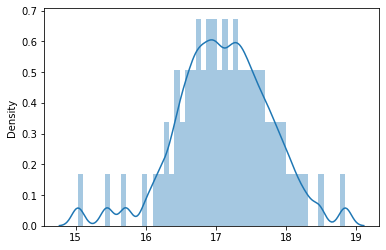

In [74]:
df1 = pd.read_csv("dataset\ADNI_coef_lm.csv")
df1.drop(['Unnamed: 0','(Intercept)','Age','GenderMale','yEdu'],axis=1,inplace=True)

df2 = pd.read_csv("dataset\CSF_Proteomics_ADNI.csv")
#replace categorical feature with index labeling
df2['binary_class'].replace({'stable':0,'decliner':1},inplace=True)
df2['three_class'].replace({'slowDecline':0,'rapidDecline':1,'stable':2},inplace=True)

#differentiate other categorical features from the numerical ones
pheno = df2.loc[:,'RID':'VISCODE']
data = df2.loc[:,'A1AT.AVLTIDEK':'VTDB.VPTADLEDVLPLAEDITNILSK']
data['binary_class'] = pheno['binary_class']
data['three_class'] = pheno['three_class']
data['RID'] = pheno['RID']

#merge two datasets
df = pd.merge(df1, data, on="RID")
df.drop(['RID'],axis=1,inplace=True)

X = df.drop(columns = ['variable_num','binary_class','three_class'])
y = df["variable_num"]

#normally test function -> check if each column is normally distr
def norm_test(data):
    alpha = 1e-3
    k2, p = stats.normaltest(data)
    count=0
    for i in p:
        if i > alpha:  # null hypothesis: x comes from a normal distribution
            count+=1
    print('There are ',count,'normally distributed features out of',data.shape[1])
    
#QUANTILE NORMALIZATION
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values,axis=0),index=df.index,columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return df_qn

# compute quantile normalized data
df_qn=quantile_normalize(X)
data = df_qn
norm_test(data)

#compute box-cox transformation
df_bc = pd.DataFrame().reindex_like(data)

for col in df_qn:
    df_bc[col],_ = stats.boxcox(df_qn[col])
data = df_qn
norm_test(data)

#check if data is better normally distributed
sns.distplot(data)

In [75]:
from sklearn.decomposition import PCA

pca = PCA(.80)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

new_X = pd.concat([X.reset_index(drop=True), principalDf.reset_index(drop=True)], axis=1)

#fill NaN values with mean of 
print('Note that we now have',new_X.shape[1],'columns instead of',X.shape[1],'(origin dataset + PCA components)')

#I want 5 bins in order to have stratified sample
bins = np.linspace(0, y.shape[0], 5)
y_binned = np.digitize(y, bins)

X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(new_X, y, test_size = 0.20, random_state = 97,stratify=y_binned)
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(new_X, y, test_size = 0.40, random_state = 97,stratify=y_binned)

Note that we now have 330 columns instead of 320 (origin dataset + PCA components)


## Test on commonly used models

In [76]:
def avg_slope(y_test,model_predicts,model_name):

    fig, ax = plt.subplots()
    ax.scatter(y_test,model_predicts)
    ax.set_xlim((-1,0.25))
    ax.set_ylim((-1,0.25))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    xpoints = ypoints = plt.xlim()
    ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Scatter plot of '+(model_name+' predictions')+' vs true values')
    plt.ylabel((model_name+' predictions'))
    plt.xlabel('True values')
    plt.show()
    
    if len(model_predicts.shape)>1:
        model_predicts = [item[0] for item in model_predicts]
    
    PRESS = (np.sum(np.square(y_test - model_predicts)))
    TSS = ((y_test - np.mean(y_test))**2).sum()
    Q_square = 1-(PRESS/TSS)
    print("Q-square =",Q_square)

In [77]:
def check_acc(X_train,y_train,X_test,y_test,model):
    model.fit(X_train,y_train)
    y_predicted = model.predict(X_test)

    print("RMSE =", math.sqrt(mean_squared_error(y_test, y_predicted)))
    print("MAE =", mean_absolute_error(y_test, y_predicted))
    
    y_test = [item for item in y_test]
    
    plt.plot(y_test, label="original")
    plt.plot(y_predicted, label="predicted")
    plt.ylabel('Decline slope')
    plt.xlabel('Patients')
    plt.legend()
    plt.show()
    
    return y_predicted

### XGB Classifier

In [78]:
def XGB_class(X_train, X_test, y_train, y_test):
    clf = xgb.XGBRegressor()
    return check_acc(X_train, y_train, X_test, y_test,clf)

On Test set:
Using 20% as test subset:
RMSE = 0.293020298716573
MAE = 0.254879389127479


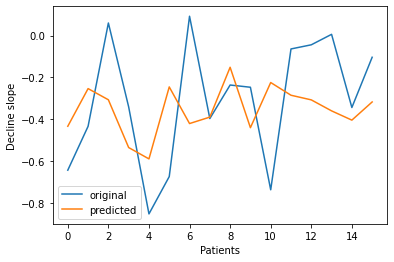

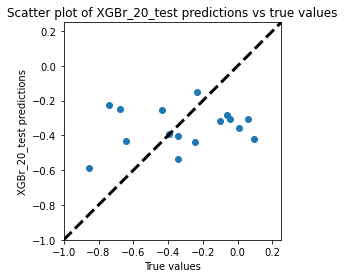

Q-square = -0.035112000528857656
Using 40% as test subset:
RMSE = 0.3060673693442561
MAE = 0.26474188178369684


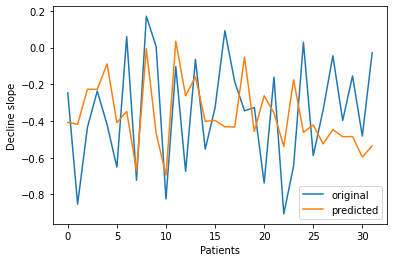

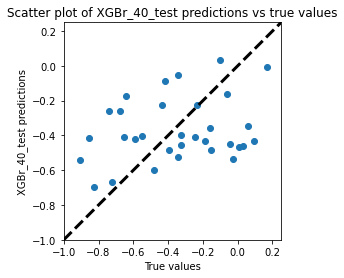

Q-square = -0.04923034243156299


In [79]:
print('On Test set:')
print('Using 20% as test subset:')
y_preds_20_XGB = XGB_class(X_train_20,X_test_20,y_train_20,y_test_20)
avg_slope(y_test_20,y_preds_20_XGB,'XGBr_20_test')
print('Using 40% as test subset:')
y_preds_40_XGB = XGB_class(X_train_40,X_test_40,y_train_40,y_test_40)
avg_slope(y_test_40,y_preds_40_XGB,'XGBr_40_test')

On Train set:
Using 20% as test subset:
RMSE = 0.00034219485966848406
MAE = 0.0002519706520926865


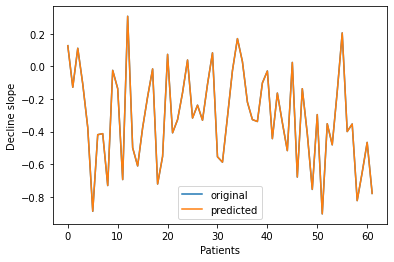

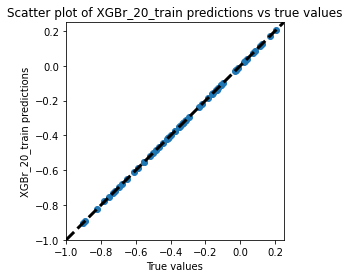

Q-square = 0.9999985971004686
Using 40% as test subset:
RMSE = 0.0003780211897395134
MAE = 0.0002466767504819267


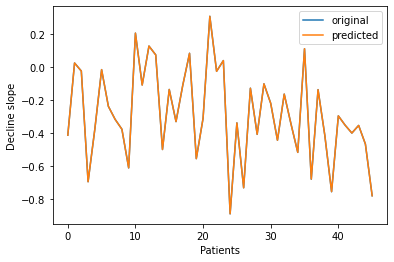

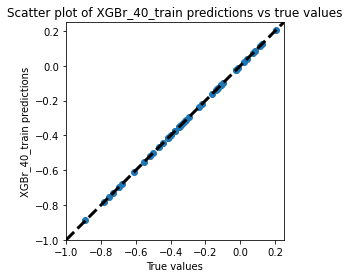

Q-square = 0.9999981599326299


In [80]:
print('On Train set:')
print('Using 20% as test subset:')
y_preds_20_XGB_train = XGB_class(X_train_20,X_train_20,y_train_20,y_train_20)
avg_slope(y_train_20,y_preds_20_XGB_train,'XGBr_20_train')
print('Using 40% as test subset:')
y_preds_40_XGB_train = XGB_class(X_train_40,X_train_40,y_train_40,y_train_40)
avg_slope(y_train_40,y_preds_40_XGB_train,'XGBr_40_train')

### Linear Regression

On Test set:
Using 20% as test subset:
RMSE = 0.38511494778782934
MAE = 0.29553996920534253


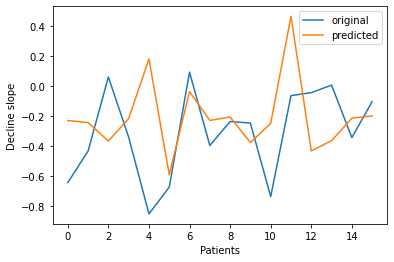

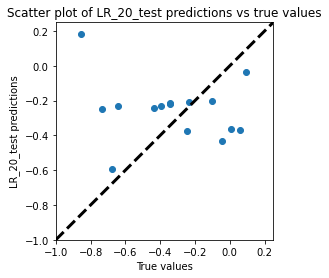

Q-square = -0.7880212719139881
Using 40% as test subset:
RMSE = 0.42357002883833117
MAE = 0.3350893939497577


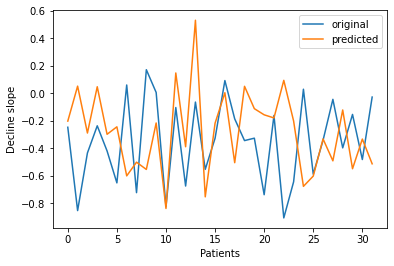

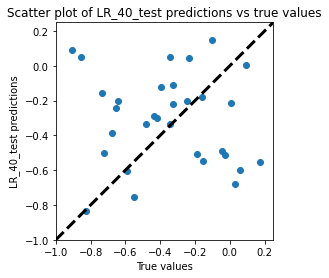

Q-square = -1.0094963645521484


In [81]:
print('On Test set:')
print('Using 20% as test subset:')
y_preds_20_LR = check_acc(X_train_20,y_train_20,X_test_20,y_test_20,LinearRegression())
avg_slope(y_test_20,y_preds_20_LR,'LR_20_test')
print('Using 40% as test subset:')
y_preds_40_LR = check_acc(X_train_40,y_train_40,X_test_40,y_test_40,LinearRegression())
avg_slope(y_test_40,y_preds_40_LR,'LR_40_test')

On Train set:
Using 20% as test subset:
RMSE = 6.040758075554328e-15
MAE = 4.87714707329789e-15


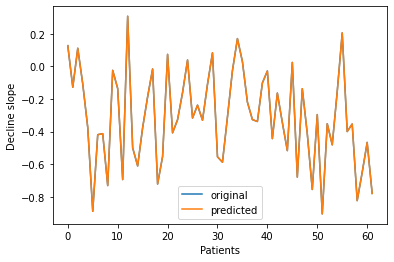

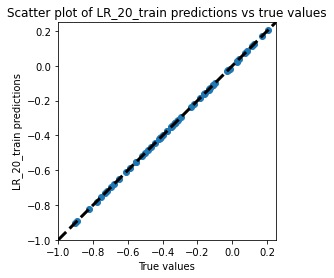

Q-square = 1.0
Using 40% as test subset:
RMSE = 6.012550153286691e-15
MAE = 5.067579809887204e-15


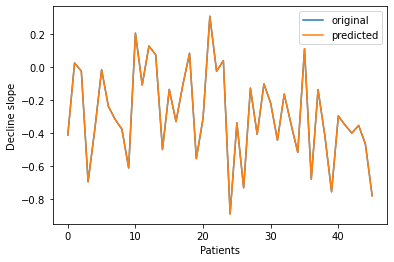

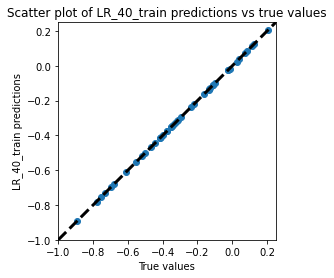

Q-square = 1.0


In [82]:
print('On Train set:')
print('Using 20% as test subset:')
y_preds_20_LR_train = check_acc(X_train_20,y_train_20,X_train_20,y_train_20,LinearRegression())
avg_slope(y_train_20,y_preds_20_LR_train,'LR_20_train')
print('Using 40% as test subset:')
y_preds_40_LR_train = check_acc(X_train_40,y_train_40,X_train_40,y_train_40,LinearRegression())
avg_slope(y_train_40,y_preds_40_LR_train,'LR_40_train')

## Features Selection

### Backward feature selection:  Recursive Feature Elimination (RFE)

### Test on XGB classifier using RFE selected features

In [83]:
def rfe_xgb(X_train, y_train,X_test):
    min_features_to_select = 1
    
    clf = xgb.XGBRegressor()
    rfecv = RFECV(estimator=clf,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train)
    
    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    newX_test = X_test[X_test.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])
    
    return newX_train,newX_test

On Test set:
Using 20% as test subset:
We kept 21 features out of the 330
RMSE = 0.29490679764777217
MAE = 0.24848009005998767


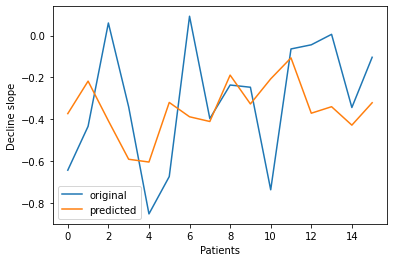

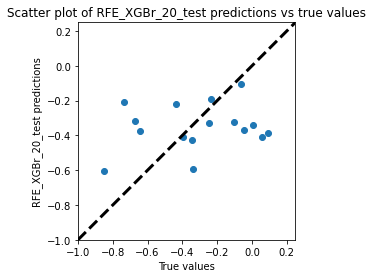

Q-square = -0.0484832493329006
Using 40% as test subset:
We kept 1 features out of the 330
RMSE = 0.40951256022982513
MAE = 0.3154013988955456


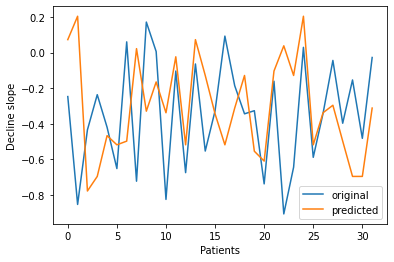

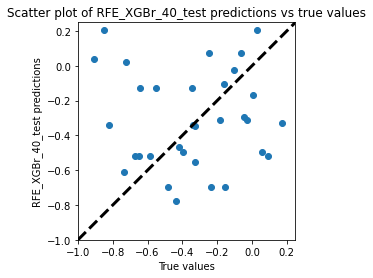

Q-square = -0.8783271372357133


In [84]:
print('On Test set:')
print('Using 20% as test subset:')
newX_train_20,newX_test_20 = rfe_xgb(X_train_20, y_train_20,X_test_20)
y_preds_20_RFE_XGB = XGB_class(newX_train_20,newX_test_20,y_train_20,y_test_20)
avg_slope(y_test_20,y_preds_20_RFE_XGB,'RFE_XGBr_20_test')

print('Using 40% as test subset:')
newX_train_40,newX_test_40 = rfe_xgb(X_train_40, y_train_40,X_test_40)
y_preds_40_RFE_XGB = XGB_class(newX_train_40,newX_test_40,y_train_40,y_test_40)
avg_slope(y_test_40,y_preds_40_RFE_XGB,'RFE_XGBr_40_test')

On Train set:
Using 20% as test subset:
We kept 21 features out of the 330
RMSE = 0.0005032638269803683
MAE = 0.0003862350654996045


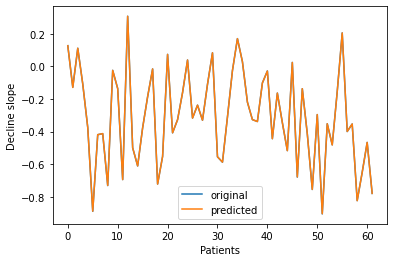

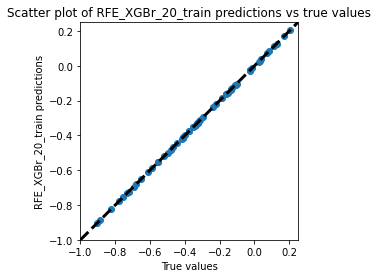

Q-square = 0.9999969656125122
Using 40% as test subset:
We kept 1 features out of the 330
RMSE = 0.0017733359687820732
MAE = 0.0014940935157765783


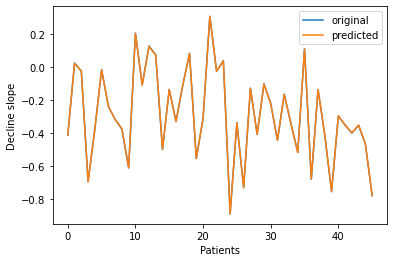

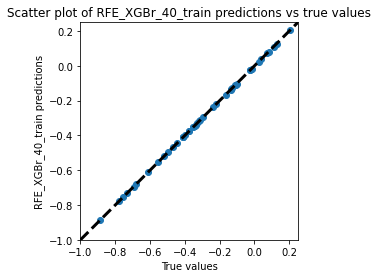

Q-square = 0.9999595066711142


In [85]:
print('On Train set:')
print('Using 20% as test subset:')
newX_train_20,newX_test_20 = rfe_xgb(X_train_20, y_train_20,X_test_20)
y_preds_20_RFE_XGB_train = XGB_class(newX_train_20,newX_train_20,y_train_20,y_train_20)
avg_slope(y_train_20,y_preds_20_RFE_XGB_train,'RFE_XGBr_20_train')

print('Using 40% as test subset:')
newX_train_40,newX_test_40 = rfe_xgb(X_train_40, y_train_40,X_test_40)
y_preds_40_RFE_XGB_train = XGB_class(newX_train_40,newX_train_40,y_train_40,y_train_40)
avg_slope(y_train_40,y_preds_40_RFE_XGB_train,'RFE_XGBr_40_train')

## Elastic Net (with hyperparameters)

a penalized linear regression model that includes both the L1 and L2 penalties during training. Using the terminology from “The Elements of Statistical Learning,” a hyperparameter “alpha” is provided to assign how much weight is given to each of the L1 and L2 penalties

In [86]:
def Elastic_Net(X_train,y_train,X_test,y_test,alpha,l1_ratio):
    #hyperparameters found above:
    print('alpha: %f' % alpha)
    print('l1_ratio: %f' % l1_ratio)

    #play around with parameters to check changes
    alpha-=0
    l1_ratio+=0

    # define model
    model = ElasticNet(alpha = alpha, l1_ratio=l1_ratio)
    return check_acc(X_train,y_train,X_test,y_test,model)

##### Cross validation for the two parameters

In [ ]:
def Elastic_NetCV(X_train, y_train):
    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define model
    ratios = arange(0, 1, 0.1)
    alphas = arange(0, 10, 1)
    model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
    # fit model
    model.fit(X_train, y_train)

    alpha = model.alpha_
    l1_ratio=model.l1_ratio_
    
    return alpha, l1_ratio

On Test set:
Using 20% as test subset:
alpha: 9.000000
l1_ratio: 0.100000
RMSE = 0.28800774813439745
MAE = 0.24284431163640055


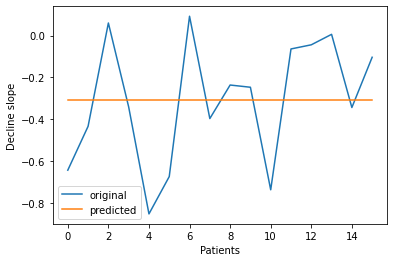

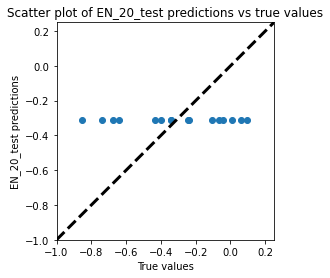

Q-square = -6.289441720763733e-07
Using 40% as test subset:
alpha: 1.000000
l1_ratio: 0.200000
RMSE = 0.29875027223208883
MAE = 0.25136588884815914


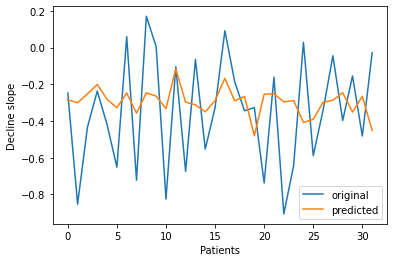

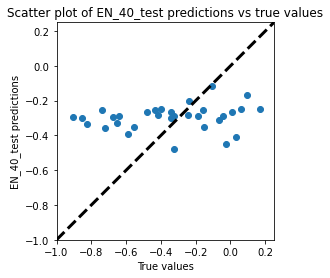

Q-square = 0.00033750384002995126


In [87]:
print('On Test set:')
print('Using 20% as test subset:')
alpha_20,l1_ratio_20 = Elastic_NetCV(X_train_20, y_train_20)
y_preds_20_EN = Elastic_Net(X_train_20,y_train_20,X_test_20,y_test_20,alpha_20,l1_ratio_20)
avg_slope(y_test_20,y_preds_20_EN,'EN_20_test')

print('Using 40% as test subset:')
alpha_40,l1_ratio_40 = Elastic_NetCV(X_train_40, y_train_40)
y_preds_40_EN = Elastic_Net(X_train_40,y_train_40,X_test_40,y_test_40,alpha_40,l1_ratio_40)
avg_slope(y_test_40,y_preds_40_EN,'EN_40_test')

On Train set:
Using 20% as test subset:
alpha: 9.000000
l1_ratio: 0.100000
RMSE = 0.2889084181089597
MAE = 0.23589456749774385


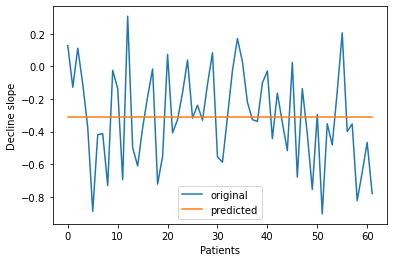

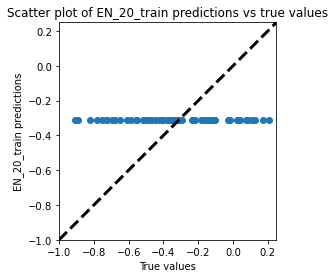

Q-square = 2.220446049250313e-16
Using 40% as test subset:
alpha: 1.000000
l1_ratio: 0.200000
RMSE = 0.24816069583141814
MAE = 0.20587087935926038


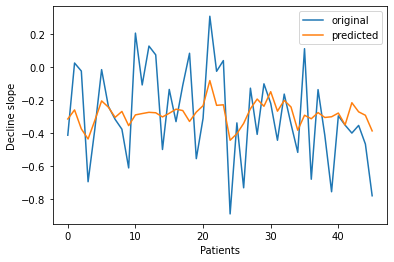

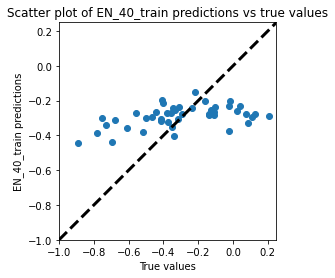

Q-square = 0.20701051023052242


In [88]:
print('On Train set:')
print('Using 20% as test subset:')
alpha_20,l1_ratio_20 = Elastic_NetCV(X_train_20, y_train_20)
y_preds_20_EN_train = Elastic_Net(X_train_20,y_train_20,X_train_20,y_train_20,alpha_20,l1_ratio_20)
avg_slope(y_train_20,y_preds_20_EN_train,'EN_20_train')

print('Using 40% as test subset:')
alpha_40,l1_ratio_40 = Elastic_NetCV(X_train_40, y_train_40)
y_preds_40_EN_train = Elastic_Net(X_train_40,y_train_40,X_train_40,y_train_40,alpha_40,l1_ratio_40)
avg_slope(y_train_40,y_preds_40_EN_train,'EN_40_train')

## Sparse Partial Least Square

Partial least squares regression reduces the number of variables by projecting independent variables onto latent structures. Sparse PLS combines variable selection and modeling in a one-step procedure.### Test on LR classifier using RFE selected features

##### Cross validation for the parameter

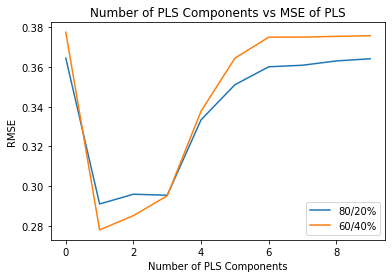

In [89]:
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection

def cross_val(X_train,y_train):
    #define cross-validation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    perf = []
    # Calculate MSE using cross-validation, adding one component at a time
    NCs = arange(0, 10, 1)
    for i in NCs:
        pls = PLSRegression(n_components=i)
        score = math.sqrt(-1*model_selection.cross_val_score(pls, X_train, y_train, cv=cv,
                   scoring='neg_mean_squared_error').mean())
        perf.append(score)

    #plot test MSE vs. number of components
    plt.plot(perf)
    plt.xlabel('Number of PLS Components')
    plt.ylabel('RMSE')
    plt.title('Number of PLS Components vs MSE of PLS')
    
cross_val(X_train_20,y_train_20)
cross_val(X_train_40,y_train_40)
plt.legend(['80/20%','60/40%'])

On Test set:
Using 20% as test subset:
RMSE = 0.26124546138188504
MAE = 0.22368414493740024


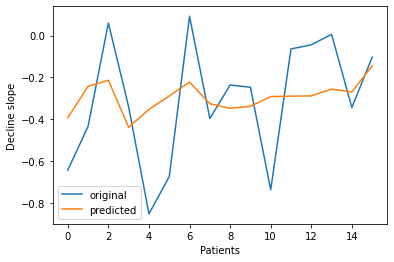

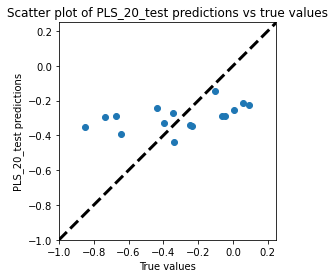

Q-square = 0.17720917831184613
Using 40% as test subset:
RMSE = 0.2868984795135935
MAE = 0.24854800530783494


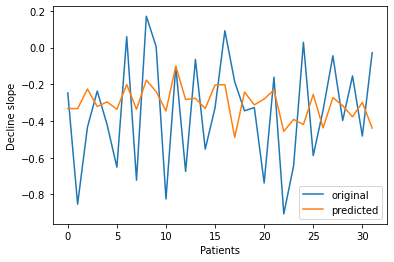

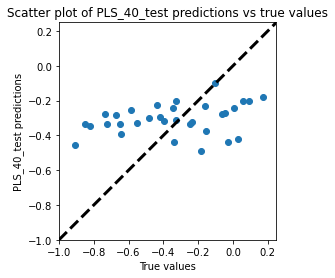

Q-square = 0.07807992270332331


In [90]:
print('On Test set:')
print('Using 20% as test subset:')
pls2_20 = PLSRegression(n_components=1)
y_preds_20_PLS = check_acc(X_train_20,y_train_20,X_test_20,y_test_20,pls2_20)
avg_slope(y_test_20,y_preds_20_PLS,'PLS_20_test')

print('Using 40% as test subset:')
pls2_40 = PLSRegression(n_components=1)
y_preds_40_PLS = check_acc(X_train_40,y_train_40,X_test_40,y_test_40,pls2_40)
avg_slope(y_test_40,y_preds_40_PLS,'PLS_40_test')

On Train set:
Using 20% as test subset:
RMSE = 0.2747202893985501
MAE = 0.22925864896364073


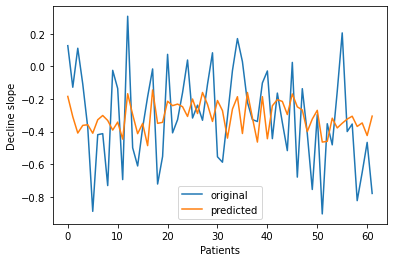

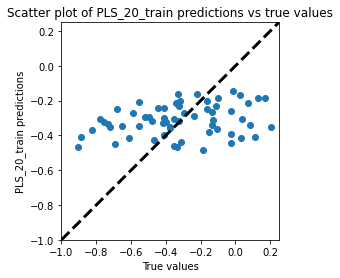

Q-square = 0.09580713030234234
Using 40% as test subset:
RMSE = 0.26172356128376767
MAE = 0.21360232490574302


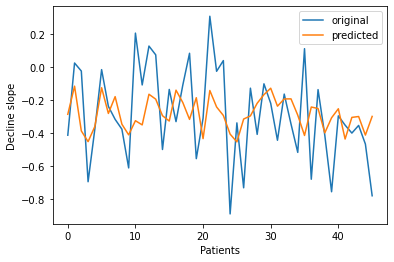

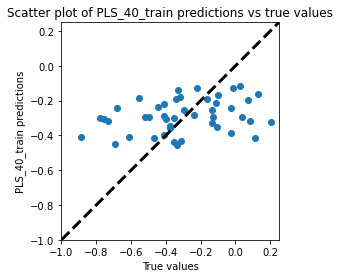

Q-square = 0.1179624442739482


In [91]:
print('On Train set:')
print('Using 20% as test subset:')
pls2_20 = PLSRegression(n_components=1)
y_preds_20_PLS_train = check_acc(X_train_20,y_train_20,X_train_20,y_train_20,pls2_20)
avg_slope(y_train_20,y_preds_20_PLS_train,'PLS_20_train')

print('Using 40% as test subset:')
pls2_40 = PLSRegression(n_components=1)
y_preds_40_PLS_train = check_acc(X_train_40,y_train_40,X_train_40,y_train_40,pls2_40)
avg_slope(y_train_40,y_preds_40_PLS_train,'PLS_40_train')